### 2.Build a LSTM to predict the stock price for multivariate data(use multiple features).Use any online website or tiingo to get the dataset.

In [117]:
import pandas_datareader as pdr
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
key=""
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [118]:
df.to_csv('apple.csv')
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
AAPL   2017-01-13 00:00:00+00:00  119.04  119.62  ...      0.0          1.0
       2017-01-17 00:00:00+00:00  120.00  120.24  ...      0.0          1.0
       2017-01-18 00:00:00+00:00  119.99  120.50  ...      0.0          1.0
       2017-01-19 00:00:00+00:00  119.78  120.09  ...      0.0          1.0
       2017-01-20 00:00:00+00:00  120.00  120.45  ...      0.0          1.0

[5 rows x 12 columns]

In [119]:
df=df.reset_index()
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-01-13 00:00:00+00:00,119.04,119.62,118.8100,119.11,26111948,28.009183,28.145653,27.955066,28.025654,104447792,0.0,1.0
1,AAPL,2017-01-17 00:00:00+00:00,120.00,120.24,118.2200,118.34,34439843,28.235064,28.291534,27.816243,27.844479,137759372,0.0,1.0
2,AAPL,2017-01-18 00:00:00+00:00,119.99,120.50,119.7100,120.00,23712961,28.232711,28.352710,28.166829,28.235064,94851844,0.0,1.0
3,AAPL,2017-01-19 00:00:00+00:00,119.78,120.09,119.3700,119.40,25597291,28.183299,28.256240,28.086830,28.093888,102389164,0.0,1.0
4,AAPL,2017-01-20 00:00:00+00:00,120.00,120.45,119.7346,120.45,32597892,28.235064,28.340945,28.172617,28.340945,130391568,0.0,1.0


In [120]:
len(df)

1258

In [121]:
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(5))

1253   2022-01-05 00:00:00+00:00
1254   2022-01-06 00:00:00+00:00
1255   2022-01-07 00:00:00+00:00
1256   2022-01-10 00:00:00+00:00
1257   2022-01-11 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]


In [122]:
cols = list(df)[2:6]
print(cols)

['close', 'high', 'low', 'open']


In [123]:
df_for_training = df[cols].astype(float)
df_for_training.tail(5)

,close,high,low,open
1253,174.92,180.17,174.64,179.61
1254,172.00,175.30,171.64,172.70
1255,172.17,174.14,171.03,172.89
1256,172.19,172.50,168.17,169.08
1257,175.08,175.18,170.82,172.32


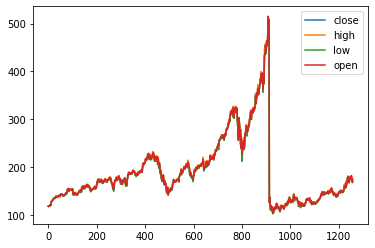

In [124]:
# plotting the features
df_for_training.plot.line()

In [125]:
# standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [126]:
df_for_training.shape

(1258, 4)

In [127]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14    # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [28]:
trainX[0]

array([[-1.02631993, -1.03303833, -1.01576669, -1.02636135],
       [-1.01247729, -1.02419516, -1.02441172, -1.03751068],
       [-1.01262149, -1.02048673, -1.00257935, -1.01347446],
       [-1.01564957, -1.02633464, -1.00756123, -1.02216225],
       [-1.01247729, -1.02119989, -1.0022189 , -1.00695862],
       [-1.01132374, -1.01606515, -1.0017002 , -1.01347446],
       [-1.01290988, -1.026192  , -1.0056564 , -1.0199903 ],
       [-0.98536879, -0.99766565, -0.99422737, -1.00739301],
       [-0.98450363, -0.99281617, -0.97488594, -0.98929345],
       [-0.98435943, -0.99409985, -0.97488594, -0.98248801],
       [-0.98897364, -1.00436934, -0.98865938, -1.00000839],
       [-0.99301108, -1.0077925 , -0.98924549, -0.99682286],
       [-0.8863074 , -0.87799758, -0.89561539, -0.91168253],
       [-0.88947967, -0.89368707, -0.88433289, -0.89799926]])

In [128]:
# coverting into numpy arrays
import numpy as np
trainX, trainY = np.array(trainX), np.array(trainY)

In [129]:
print('trainX shape is {}'.format(trainX.shape))
print('trainY shape is {}'.format(trainY.shape))

trainX shape is (1244, 14, 4)
trainY shape is (1244, 1)


In [131]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [132]:
# Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Early stopping
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [134]:
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1,callbacks=callbacks_list)

Epoch 1/100
70/70 [==============================] - 4s 20ms/step - loss: 0.4245 - val_loss: 0.0044
Epoch 2/100
70/70 [==============================] - 1s 15ms/step - loss: 0.1139 - val_loss: 0.0040
Epoch 3/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0813 - val_loss: 0.0054
Epoch 4/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0993 - val_loss: 0.0039
Epoch 5/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0711 - val_loss: 0.0065
Epoch 6/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0753 - val_loss: 0.0033
Epoch 7/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0700 - val_loss: 0.0060
Epoch 8/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0855 - val_loss: 0.0038
Epoch 9/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0699 - val_loss: 0.0030
Epoch 10/100
70/70 [==============================] - 1s 15ms/step - loss: 0.0818 - val_loss: 0.0035

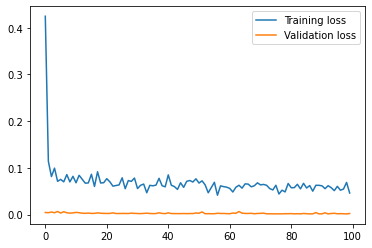

In [135]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [136]:
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 16
n_days_for_prediction=15  #let us predict past 15 days for generating dates

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2021-12-20 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-21 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-22 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-23 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-27 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-28 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-29 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2021-12-30 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-03 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-04 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-05 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-06 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-10 00:00:00+0000', tz='UTC', freq='C'), Timestamp('2022-01-11 00:00:00+0000', tz='UTC', freq='C')]


In [137]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]



In [89]:
# last value in train_dates
list(train_dates)[-1]

Timestamp('2022-01-11 00:00:00+0000', tz='UTC')

In [90]:
# dates before 15 days
list(train_dates)[-n_past]

Timestamp('2021-12-20 00:00:00+0000', tz='UTC')

In [91]:
# predicted dates
predict_period_dates

[Timestamp('2021-12-20 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-21 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-22 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-23 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-27 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-28 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-29 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2021-12-30 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-03 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-04 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-05 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-06 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-07 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-10 00:00:00+0000', tz='UTC', freq='C'),
 Timestamp('2022-01-11 00:00:00+0000', tz='UTC', freq='C')]

In [92]:
len(trainX[-n_days_for_prediction:])

15

In [138]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [139]:
df_forecast.head()

,Date,Open
0,2021-12-20,171.510452
1,2021-12-21,172.739929
2,2021-12-22,175.226471
3,2021-12-23,177.435272
4,2021-12-27,180.134308


In [140]:
# orginal dataframe
original = df[['date', 'open']]

In [95]:
original.head()

,date,open
0,2017-01-13 00:00:00+00:00,119.11
1,2017-01-17 00:00:00+00:00,118.34
2,2017-01-18 00:00:00+00:00,120.00
3,2017-01-19 00:00:00+00:00,119.40
4,2017-01-20 00:00:00+00:00,120.45


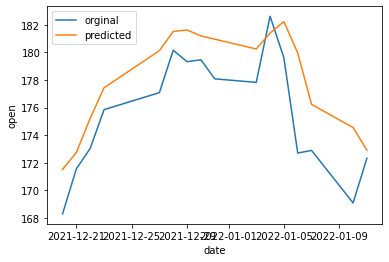

In [141]:
# plotting
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-12-20']

sns.lineplot(original['date'], original['open'],label="orginal")
sns.lineplot(df_forecast['Date'], df_forecast['Open'],label='predicted')


### Conclusion
Model is able to forecast future values not precisly. But i will be able to increase accurate by training for more epochs.